In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,make_scorer,recall_score,
    classification_report,roc_curve, auc,matthews_corrcoef
)
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from Functions import *

In [2]:
data = pd.read_csv("clean.csv")
X = data.drop("Response", axis=1)
y = data["Response"]
X_encoded = pd.get_dummies(X,drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Base

In [3]:
from sklearn.metrics import roc_auc_score,roc_curve
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train_scaled, y_train)
y_pred_lr_base = lr.predict(X_test_scaled)
y_prob_lr_base = lr.predict_proba(X_test_scaled)[:, 1]
print(confusion_matrix(y_test, y_pred_lr_base))
print(classification_report(y_test, y_pred_lr_base))
# AUC
fpr_base, tpr_base, thresholds = roc_curve(y_test, y_prob_lr_base)
auc_base = roc_auc_score(y_test, y_prob_lr_base)
print(f"Logistic Regression ROC AUC: {auc_base:.3f}")

[[3354 4381]
 [ 858 1584]]
              precision    recall  f1-score   support

           0       0.80      0.43      0.56      7735
           1       0.27      0.65      0.38      2442

    accuracy                           0.49     10177
   macro avg       0.53      0.54      0.47     10177
weighted avg       0.67      0.49      0.52     10177

Logistic Regression ROC AUC: 0.566


#### Hyperparamter Tuning

In [4]:
param_grid_lr = {
    'C': [0.01, 0.05,0.1, 0.5,1,5,10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=500),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=5,
    n_jobs= 1,
    verbose= 100
)
grid_lr.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_lr.best_params_)
print("Best F1 Score from CV:", grid_lr.best_score_)

# use the best model to predict
best_lr = grid_lr.best_estimator_
y_pred = best_lr.predict(X_test_scaled)
y_proba = best_lr.predict_proba(X_test_scaled)[:, 1]

fpr_tuned, tpr_tuned, thresholds = roc_curve(y_test, y_proba)
auc_tuned = roc_auc_score(y_test, y_proba)
print("AUC:", auc_tuned)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.05, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.05, penalty=l1, solv

#### SMOTE

In [5]:
# Apply SMOTE
print("Before SMOTE - Class distribution:", dict(pd.Series(y_train).value_counts()))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE - Class distribution:", dict(pd.Series(y_train_resampled).value_counts()))

# Train
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

fpr_sm, tpr_sm, thresholds = roc_curve(y_test, y_proba)
auc_sm = roc_auc_score(y_test, y_proba)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAUC Score:", auc_sm)

Before SMOTE - Class distribution: {0: 30938, 1: 9767}
After SMOTE - Class distribution: {0: 30938, 1: 30938}

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.44      0.56      7735
           1       0.26      0.64      0.37      2442

    accuracy                           0.48     10177
   macro avg       0.53      0.54      0.47     10177
weighted avg       0.66      0.48      0.52     10177


AUC Score: 0.5631064748711808


### Feature Engineering

#### Method 1

In [5]:
data = pd.read_csv("clean.csv")
# target encoding
cat_mean = data.groupby('Reco_Policy_Cat')['Response'].mean()
data['Reco_Policy_Cat_enc'] = data['Reco_Policy_Cat'].map(cat_mean)

city_mean = data.groupby('City_Code')['Response'].mean()
data['City_Code_enc'] = data['City_Code'].map(city_mean)

region_mean = data.groupby('Region_Code')['Response'].mean()
data['Region_Code_encoded'] = data['Region_Code'].map(region_mean)

# delete columns
data = data.drop(columns=["Reco_Policy_Cat","City_Code","Region_Code"])

# One-Hot
data = pd.get_dummies(
    data,
    columns=['Reco_Insurance_Type', 'Accomodation_Type', 'Health_Indicator', 'Holding_Policy_Type','Is_Spouse'],
    drop_first=True
)

# number
num_features = ["Upper_Age","Lower_Age", "Reco_Policy_Premium", 'Holding_Policy_Duration']
scaler = StandardScaler()
data[num_features] = scaler.fit_transform(data[num_features])

X = data.drop(columns=["Response"])
y = data["Response"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lr = LogisticRegression(
    solver="liblinear",
    class_weight="balanced",    random_state=42
)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:,1]

fpr_lr_fe, tpr_lr_fe, thresholds = roc_curve(y_test, y_prob_lr)
auc_lr_fe = roc_auc_score(y_test, y_prob_lr)
print("Logistic Regression:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("AUC: ", auc_lr_fe)

Logistic Regression:
[[5313 2422]
 [ 841 1601]]
              precision    recall  f1-score   support

           0       0.86      0.69      0.77      7735
           1       0.40      0.66      0.50      2442

    accuracy                           0.68     10177
   macro avg       0.63      0.67      0.63     10177
weighted avg       0.75      0.68      0.70     10177

AUC:  0.740128975423093


#### Method 2 - Smooth

In [6]:
data = pd.read_csv("clean.csv")
X = data.drop(columns=["Response","ID","Unnamed: 0"])
y = data["Response"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train_final, X_test_final, train_data_Response, y_test = train_smooth_encoding_model(X_train, y_train, X_test, y_test, weight=100)

# Model Training
lr_model = LogisticRegression(random_state=42, max_iter=1000,class_weight="balanced")
lr_model.fit(X_train_final, train_data_Response)
y_pred = lr_model.predict(X_test_final)
y_pred_proba = lr_model.predict_proba(X_test_final)[:, 1]

fpr_fe1, tpr_fe1, thresholds = roc_curve(y_test, y_pred_proba)
auc_fe1 = roc_auc_score(y_test, y_pred_proba)

print("Classification:\n",classification_report(y_test, y_pred))
print(f"ROC AUC: {auc_fe1:.4f}")

================== Smooth Encoding ==================
Classification:
               precision    recall  f1-score   support

           0       0.80      0.62      0.70      7735
           1       0.30      0.52      0.38      2442

    accuracy                           0.60     10177
   macro avg       0.55      0.57      0.54     10177
weighted avg       0.68      0.60      0.62     10177

ROC AUC: 0.6019


#### Method 3 - Bayesian

In [7]:
data = pd.read_csv("clean.csv")
X = data.drop(columns=["Response","ID","Unnamed: 0"])
y = data["Response"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train_final, X_test_final, train_data_Response, y_test = train_bayesian_encoding_model(X_train, y_train, X_test, y_test)

# Model Training
lr_model = LogisticRegression(random_state=42, max_iter=1000,class_weight="balanced")
lr_model.fit(X_train_final, train_data_Response)
y_pred = lr_model.predict(X_test_final)
y_pred_proba = lr_model.predict_proba(X_test_final)[:, 1]

fpr_fe2, tpr_fe2, thresholds = roc_curve(y_test, y_pred_proba)
auc_fe2 = roc_auc_score(y_test, y_pred_proba)

print("Classification:\n",classification_report(y_test, y_pred))
print(f"ROC AUC: {auc_fe2:.4f}")

============================== Bayesian ==============================
Classification:
               precision    recall  f1-score   support

           0       0.79      0.63      0.70      7735
           1       0.29      0.47      0.36      2442

    accuracy                           0.59     10177
   macro avg       0.54      0.55      0.53     10177
weighted avg       0.67      0.59      0.62     10177

ROC AUC: 0.5747


#### Method 4 - K Fold

In [16]:
def train_kfold_encoding_model(X_train, y_train, X_test, y_test, n_splits=5):
    print("=" * 30,"K Fold","=" * 30)
    categorical_cols = ['Reco_Policy_Cat', 'City_Code', 'Region_Code']

    train_data = X_train.copy()
    test_data = X_test.copy()
    train_data['Response'] = y_train.values

    def kfold_target_encode(train_df, column, target, n_splits):
        train_df[f'{column}_enc'] = 0
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(train_df):
            train_fold = train_df.iloc[train_idx]
            val_fold = train_df.iloc[val_idx]

            mean_encoding = train_fold.groupby(column)[target].mean()
            train_df.iloc[val_idx, train_df.columns.get_loc(f'{column}_enc')] = \
                val_fold[column].map(mean_encoding).fillna(train_df[target].mean())

        return train_df

    # K-Fold in Train data
    for col in categorical_cols:
        train_data = kfold_target_encode(train_data, col, 'Response', n_splits)

    # Mean in Test data
    for col in categorical_cols:
        global_mean = train_data.groupby(col)['Response'].mean()
        test_data[f'{col}_enc'] = test_data[col].map(global_mean)
        test_data[f'{col}_enc'] = test_data[f'{col}_enc'].fillna(train_data['Response'].mean())

    # Delete
    train_data = train_data.drop(columns=categorical_cols)
    test_data = test_data.drop(columns=categorical_cols)

    # One-Hot
    onehot_cols = ['Reco_Insurance_Type', 'Accomodation_Type', 'Health_Indicator',
                  'Holding_Policy_Type', 'Is_Spouse']

    train_onehot = pd.get_dummies(train_data[onehot_cols], drop_first=True)
    test_onehot = pd.get_dummies(test_data[onehot_cols], drop_first=True)

    missing_cols = set(train_onehot.columns) - set(test_onehot.columns)
    for col in missing_cols:
        test_onehot[col] = 0
    test_onehot = test_onehot[train_onehot.columns]

    # Combine
    num_features = ["Upper_Age", "Lower_Age", "Reco_Policy_Premium", 'Holding_Policy_Duration']
    X_train_final = pd.concat([train_data.drop(columns=onehot_cols + ['Response']),
                              train_onehot, train_data[num_features]], axis=1)
    X_test_final = pd.concat([test_data.drop(columns=onehot_cols),
                             test_onehot, test_data[num_features]], axis=1)

    scaler = StandardScaler()
    X_train_final[num_features] = scaler.fit_transform(X_train_final[num_features])
    X_test_final[num_features] = scaler.transform(X_test_final[num_features])

    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train_final, train_data['Response'])

    y_pred = lr_model.predict(X_test_final)
    y_pred_proba = lr_model.predict_proba(X_test_final)[:, 1]

    fpr,tpr,threshold = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("Classification",classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc:.4f}")

    # Cross Validation
    cv_scores = cross_val_score(lr_model, X_train_final, train_data['Response'],
                               cv=5, scoring='roc_auc')
    print(f"5 Fold ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    return lr_model, X_train_final, X_test_final, train_data['Response'], y_test,fpr,tpr,roc_auc

model3, X_train3, X_test3, y_train3, y_test3,fpr_fe3,tpr_fe3,auc_fe3 = train_kfold_encoding_model(X_train, y_train, X_test, y_test)

============================== K Fold ==============================
Classification               precision    recall  f1-score   support

           0       0.77      0.98      0.86      7735
           1       0.47      0.05      0.10      2442

    accuracy                           0.76     10177
   macro avg       0.62      0.52      0.48     10177
weighted avg       0.70      0.76      0.68     10177

ROC AUC: 0.6210
5 Fold ROC AUC: 0.6213 (±0.0060)


#### KFold + Interaction

In [18]:
def create_interaction_features(train_data, test_data):
    # Upper_Age * Reco_Policy_Premium
    train_data['Upper_Age_Premium_Interaction'] = train_data['Upper_Age'] * train_data['Reco_Policy_Premium']
    test_data['Upper_Age_Premium_Interaction'] = test_data['Upper_Age'] * test_data['Reco_Policy_Premium']

    # Upper_Age * Holding_Policy_Duration
    train_data['Upper_Age_Duration_Interaction'] = train_data['Upper_Age'] * train_data['Holding_Policy_Duration']
    test_data['Upper_Age_Duration_Interaction'] = test_data['Upper_Age'] * test_data['Holding_Policy_Duration']

    # Upper_Age * Health_Indicator
    health_mapping = {
        'X1': 1, 'X2': 2, 'X3': 3, 'X4': 4, 'X5': 5, 'X6': 6, 'X7': 7, 'X8': 8, 'X9': 9
    }
    default_health_value = 5

    train_data['Health_Indicator_encoded'] = train_data['Health_Indicator'].map(health_mapping)
    train_data['Health_Indicator_encoded'] = train_data['Health_Indicator_encoded'].fillna(default_health_value)

    test_data['Health_Indicator_encoded'] = test_data['Health_Indicator'].map(health_mapping)
    test_data['Health_Indicator_encoded'] = test_data['Health_Indicator_encoded'].fillna(default_health_value)

    train_data['Upper_Age_Health_Interaction'] = train_data['Upper_Age'] * train_data['Health_Indicator_encoded']
    test_data['Upper_Age_Health_Interaction'] = test_data['Upper_Age'] * test_data['Health_Indicator_encoded']

    # Holding_Policy_Duration * Reco_Policy_Cat
    train_data['Duration_PolicyCat_Interaction'] = train_data['Holding_Policy_Duration'] * train_data['Reco_Policy_Cat_enc']
    test_data['Duration_PolicyCat_Interaction'] = test_data['Holding_Policy_Duration'] * test_data['Reco_Policy_Cat_enc']

    # Reco_Policy_Premium * Reco_Insurance_Type
    insurance_mean = train_data.groupby('Reco_Insurance_Type')['Response'].mean()
    train_data['Reco_Insurance_Type_enc'] = train_data['Reco_Insurance_Type'].map(insurance_mean)
    test_data['Reco_Insurance_Type_enc'] = test_data['Reco_Insurance_Type'].map(insurance_mean)
    test_data['Reco_Insurance_Type_enc'] = test_data['Reco_Insurance_Type_enc'].fillna(train_data['Response'].mean())

    train_data['Premium_InsuranceType_Interaction'] = train_data['Reco_Policy_Premium'] * train_data['Reco_Insurance_Type_enc']
    test_data['Premium_InsuranceType_Interaction'] = test_data['Reco_Policy_Premium'] * test_data['Reco_Insurance_Type_enc']

    return train_data, test_data

def train_kfold_encoding_with_interactions(X_train, y_train, X_test, y_test, n_splits=5):
    print("=" * 30, "K-Fold Encoding + Interactions", "=" * 30)
    target_encode_cols = ['Reco_Policy_Cat', 'City_Code', 'Region_Code']

    train_data = X_train.copy()
    test_data = X_test.copy()
    train_data['Response'] = y_train.values

    # K-Fold
    for col in target_encode_cols:
        train_data = kfold_target_encode(train_data, col, 'Response', n_splits)

        global_mean = train_data.groupby(col)['Response'].mean()
        test_data[f'{col}_enc'] = test_data[col].map(global_mean)
        test_data[f'{col}_enc'] = test_data[f'{col}_enc'].fillna(train_data['Response'].mean())

    # Create interation features
    train_data, test_data = create_interaction_features(train_data, test_data)

    # delete
    columns_to_drop = target_encode_cols + ['Health_Indicator_encoded', 'Reco_Insurance_Type_enc']
    train_data = train_data.drop(columns=columns_to_drop)
    test_data = test_data.drop(columns=columns_to_drop)

    # One-Hot
    onehot_cols = ['Reco_Insurance_Type', 'Accomodation_Type', 'Health_Indicator',
                  'Holding_Policy_Type', 'Is_Spouse']

    train_onehot = pd.get_dummies(train_data[onehot_cols], drop_first=True)
    test_onehot = pd.get_dummies(test_data[onehot_cols], drop_first=True)

    missing_cols = set(train_onehot.columns) - set(test_onehot.columns)
    for col in missing_cols:
        test_onehot[col] = 0
    test_onehot = test_onehot[train_onehot.columns]

    # Combine
    num_features = ["Upper_Age", "Lower_Age", "Reco_Policy_Premium", 'Holding_Policy_Duration']
    interaction_cols = [col for col in train_data.columns if 'Interaction' in col]

    X_train_final = pd.concat([
        train_data.drop(columns=onehot_cols + ['Response']),
        train_onehot,
        train_data[num_features + interaction_cols]
    ], axis=1)

    X_test_final = pd.concat([
        test_data.drop(columns=onehot_cols),
        test_onehot,
        test_data[num_features + interaction_cols]
    ], axis=1)

    features_to_scale = num_features + interaction_cols
    scaler = StandardScaler()
    X_train_final[features_to_scale] = scaler.fit_transform(X_train_final[features_to_scale])
    X_test_final[features_to_scale] = scaler.transform(X_test_final[features_to_scale])

    # Train and Evaluate
    lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    lr_model.fit(X_train_final, train_data['Response'])

    y_pred = lr_model.predict(X_test_final)
    y_pred_proba = lr_model.predict_proba(X_test_final)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc:.4f}")

    cv_scores = cross_val_score(lr_model, X_train_final, train_data['Response'],
                               cv=5, scoring='roc_auc')
    print(f"5 Fold ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    return lr_model, X_train_final, X_test_final, train_data['Response'], y_test,roc_auc,fpr,tpr

if __name__ == "__main__":
    data = pd.read_csv("clean.csv")
    X = data.drop(columns=["Response","ID","Unnamed: 0"])
    y = data["Response"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model, X_train_final, X_test_final, y_train_final, y_test_final,auc_fe4,fpr_fe4,tpr_fe4 = train_kfold_encoding_with_interactions(
        X_train, y_train, X_test, y_test
    )

============================== K-Fold Encoding + Interactions ==============================
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.59      0.69      7735
           1       0.31      0.57      0.40      2442

    accuracy                           0.59     10177
   macro avg       0.56      0.58      0.54     10177
weighted avg       0.69      0.59      0.62     10177

ROC AUC: 0.6220
5 Fold ROC AUC: 0.6212 (±0.0058)


#### KFold + Interation + Tuning

In [12]:
def tune_logistic_regression(X_train, y_train, scoring='roc_auc'):
    param_grid = {
        'C': [0.01, 0.05,0.1, 0.5,1,5,10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }

    grid_search = GridSearchCV(
        estimator=LogisticRegression(random_state=42, max_iter=1000,class_weight='balanced'),
        param_grid=param_grid,
        scoring=scoring,
        cv=5,
        n_jobs= 1,
        verbose= 2
    )

    grid_search.fit(X_train, y_train)

    print(f"Best params: {grid_search.best_params_}")
    print(f"Best cross validation {scoring} score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr,tpr,_ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:\n:",classification_report(y_test, y_pred))

    return {
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'fpr':fpr,
        'tpr':tpr
    }

def prepare_features_with_kfold_encoding(X_train, y_train, X_test, n_splits=5):
    target_encode_cols = ['Reco_Policy_Cat', 'City_Code', 'Region_Code']

    train_data = X_train.copy()
    test_data = X_test.copy()
    train_data['Response'] = y_train.values

    for col in target_encode_cols:
        train_data = kfold_target_encode(train_data, col, 'Response', n_splits)
        global_mean = train_data.groupby(col)['Response'].mean()
        test_data[f'{col}_enc'] = test_data[col].map(global_mean)
        test_data[f'{col}_enc'] = test_data[f'{col}_enc'].fillna(train_data['Response'].mean())

    train_data, test_data = create_interaction_features(train_data, test_data)

    # delete
    columns_to_drop = target_encode_cols + ['Health_Indicator_encoded', 'Reco_Insurance_Type_enc']
    train_data = train_data.drop(columns=columns_to_drop)
    test_data = test_data.drop(columns=columns_to_drop)

    onehot_cols = ['Reco_Insurance_Type', 'Accomodation_Type', 'Health_Indicator',
                  'Holding_Policy_Type', 'Is_Spouse']

    train_onehot = pd.get_dummies(train_data[onehot_cols], drop_first=True)
    test_onehot = pd.get_dummies(test_data[onehot_cols], drop_first=True)

    missing_cols = set(train_onehot.columns) - set(test_onehot.columns)
    for col in missing_cols:
        test_onehot[col] = 0
    test_onehot = test_onehot[train_onehot.columns]
    num_features = ["Upper_Age", "Lower_Age", "Reco_Policy_Premium", 'Holding_Policy_Duration']
    interaction_cols = [col for col in train_data.columns if 'Interaction' in col]

    X_train_final = pd.concat([
        train_data.drop(columns=onehot_cols + ['Response']),
        train_onehot,
        train_data[num_features + interaction_cols]
    ], axis=1)

    X_test_final = pd.concat([
        test_data.drop(columns=onehot_cols),
        test_onehot,
        test_data[num_features + interaction_cols]
    ], axis=1)
    features_to_scale = num_features + interaction_cols
    scaler = StandardScaler()
    X_train_final[features_to_scale] = scaler.fit_transform(X_train_final[features_to_scale])
    X_test_final[features_to_scale] = scaler.transform(X_test_final[features_to_scale])

    return X_train_final, X_test_final, train_data['Response']

def train_with_parameter_tuning(X_train, y_train, X_test, y_test, scoring='roc_auc'):
    X_train_final, X_test_final, y_train_final = prepare_features_with_kfold_encoding(
        X_train, y_train, X_test
    )

    best_model, best_params, best_score = tune_logistic_regression(
        X_train_final, y_train_final, scoring
    )

    # Evaluation
    evaluation_results = evaluate_model(best_model, X_test_final, y_test)

    # Cross validation
    cv_scores = cross_val_score(best_model, X_train_final, y_train_final,
                               cv=5, scoring='roc_auc')
    print(f"5 fold cross validation ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    return {
        'model': best_model,
        'best_params': best_params,
        'best_cv_score': best_score,
        'X_train': X_train_final,
        'X_test': X_test_final,
        'y_train': y_train_final,
        'y_test': y_test,
        'evaluation': evaluation_results,
        'cv_scores': cv_scores
    }

if __name__ == "__main__":
    data = pd.read_csv("clean.csv")
    X = data.drop(columns=["Response","ID","Unnamed: 0"])
    y = data["Response"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    result = train_with_parameter_tuning(X_train, y_train, X_test, y_test, scoring='roc_auc')
    fpr_fe5= result['evaluation']['fpr']
    tpr_fe5= result['evaluation']['tpr']
    auc_fe5 = result['evaluation']['roc_auc']
    print(f"Best params: {result['best_params']}")
    print(f"Best cross validation score: {result['best_cv_score']:.4f}")
    print(f"Test set ROC AUC: {result['evaluation']['roc_auc']:.4f}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.05, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.05, penalty=l1, solv

#### Tuning plot

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5; 1/14] START C=0.01, penalty=l1, solver=liblinear.......................
[CV 1/5; 1/14] END C=0.01, penalty=l1, solver=liblinear;, score=0.618 total time=   0.0s
[CV 2/5; 1/14] START C=0.01, penalty=l1, solver=liblinear.......................
[CV 2/5; 1/14] END C=0.01, penalty=l1, solver=liblinear;, score=0.632 total time=   0.0s
[CV 3/5; 1/14] START C=0.01, penalty=l1, solver=liblinear.......................
[CV 3/5; 1/14] END C=0.01, penalty=l1, solver=liblinear;, score=0.615 total time=   0.0s
[CV 4/5; 1/14] START C=0.01, penalty=l1, solver=liblinear.......................
[CV 4/5; 1/14] END C=0.01, penalty=l1, solver=liblinear;, score=0.615 total time=   0.0s
[CV 5/5; 1/14] START C=0.01, penalty=l1, solver=liblinear.......................
[CV 5/5; 1/14] END C=0.01, penalty=l1, solver=liblinear;, score=0.625 total time=   0.0s
[CV 1/5; 2/14] START C=0.01, penalty=l2, solver=liblinear.......................
[CV 1/5;

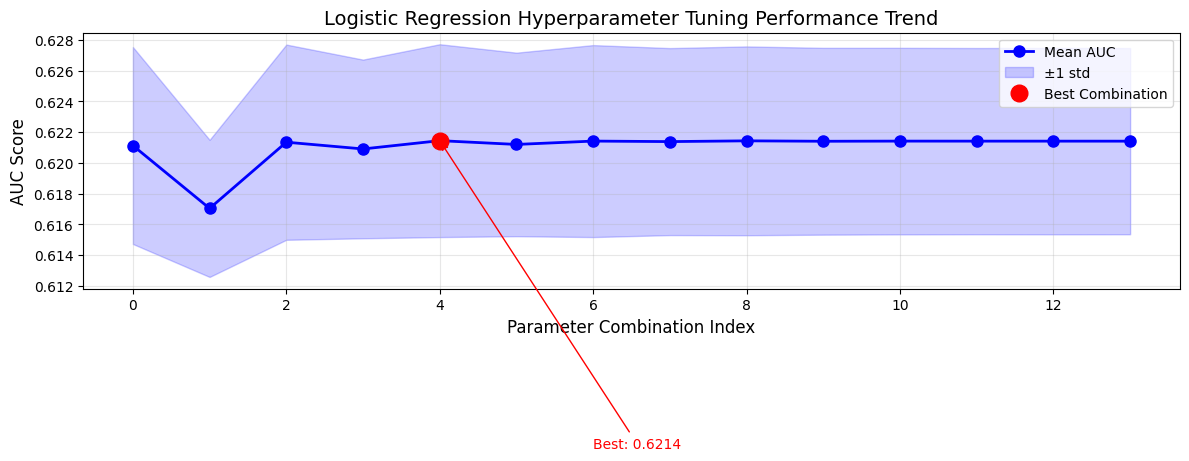

Best parameter combination details:
Combination index: 4
Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
AUC Score: 0.6214
Standard deviation: 0.0063
ROC AUC: 0.6214
Classification Report:
:               precision    recall  f1-score   support

           0       0.81      0.59      0.68      7735
           1       0.31      0.57      0.40      2442

    accuracy                           0.59     10177
   macro avg       0.56      0.58      0.54     10177
weighted avg       0.69      0.59      0.62     10177

5 fold cross validation ROC AUC: 0.6214 (±0.0063)
Best params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross validation score: 0.6214
Test set ROC AUC: 0.6214


In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

def plot_tuning_trend(grid_search, model_name="Model"):
    results = grid_search.cv_results_

    plt.figure(figsize=(12, 6))

    plt.plot(range(len(results['params'])), results['mean_test_score'],
            'o-', linewidth=2, markersize=8, color='blue', label='Mean AUC')

    plt.fill_between(range(len(results['params'])),
                    results['mean_test_score'] - results['std_test_score'],
                    results['mean_test_score'] + results['std_test_score'],
                    alpha=0.2, color='blue', label='±1 std')

    best_idx = np.argmax(results['mean_test_score'])
    plt.plot(best_idx, results['mean_test_score'][best_idx], 'ro',
            markersize=12, label='Best Combination')

    plt.xlabel('Parameter Combination Index', fontsize=12)
    plt.ylabel('AUC Score', fontsize=12)
    plt.title(f'{model_name} Hyperparameter Tuning Performance Trend', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.annotate(f'Best: {results["mean_test_score"][best_idx]:.4f}',
                xy=(best_idx, results['mean_test_score'][best_idx]),
                xytext=(best_idx+2, results['mean_test_score'][best_idx]-0.02),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red')

    plt.tight_layout()
    plt.show()

    return best_idx

def tune_logistic_regression(X_train, y_train, scoring='roc_auc'):
    param_grid = {
        'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }

    grid_search = GridSearchCV(
        estimator=LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        param_grid=param_grid,
        scoring=scoring,
        cv=5,
        n_jobs=1,
        verbose=100
    )

    grid_search.fit(X_train, y_train)

    print(f"Best params: {grid_search.best_params_}")
    print(f"Best cross validation {scoring} score: {grid_search.best_score_:.4f}")

    best_idx = plot_tuning_trend(grid_search, model_name="Logistic Regression")

    print(f"Best parameter combination details:")
    print(f"Combination index: {best_idx}")
    print(f"Parameters: {grid_search.cv_results_['params'][best_idx]}")
    print(f"AUC Score: {grid_search.best_score_:.4f}")
    print(f"Standard deviation: {grid_search.cv_results_['std_test_score'][best_idx]:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_, grid_search

def train_with_parameter_tuning(X_train, y_train, X_test, y_test, scoring='roc_auc'):
    X_train_final, X_test_final, y_train_final = prepare_features_with_kfold_encoding(
        X_train, y_train, X_test
    )

    best_model, best_params, best_score, grid_search = tune_logistic_regression(
        X_train_final, y_train_final, scoring
    )

    # Evaluation
    evaluation_results = evaluate_model(best_model, X_test_final, y_test)

    # Cross validation
    cv_scores = cross_val_score(best_model, X_train_final, y_train_final,
                               cv=5, scoring='roc_auc')
    print(f"5 fold cross validation ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    return {
        'model': best_model,
        'best_params': best_params,
        'best_cv_score': best_score,
        'X_train': X_train_final,
        'X_test': X_test_final,
        'y_train': y_train_final,
        'y_test': y_test,
        'evaluation': evaluation_results,
        'cv_scores': cv_scores,
        'grid_search': grid_search
    }

def kfold_target_encode(train_df, column, target, n_splits=5):
    train_df[f'{column}_enc'] = 0
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(train_df):
        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]

        mean_encoding = train_fold.groupby(column)[target].mean()
        train_df.iloc[val_idx, train_df.columns.get_loc(f'{column}_enc')] = \
            val_fold[column].map(mean_encoding).fillna(train_df[target].mean())

    return train_df

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr,tpr,_ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:\n:",classification_report(y_test, y_pred))

    return {
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'fpr':fpr,
        'tpr':tpr
    }

def prepare_features_with_kfold_encoding(X_train, y_train, X_test, n_splits=5):
    target_encode_cols = ['Reco_Policy_Cat', 'City_Code', 'Region_Code']

    train_data = X_train.copy()
    test_data = X_test.copy()
    train_data['Response'] = y_train.values

    for col in target_encode_cols:
        train_data = kfold_target_encode(train_data, col, 'Response', n_splits)
        global_mean = train_data.groupby(col)['Response'].mean()
        test_data[f'{col}_enc'] = test_data[col].map(global_mean)
        test_data[f'{col}_enc'] = test_data[f'{col}_enc'].fillna(train_data['Response'].mean())

    train_data, test_data = create_interaction_features(train_data, test_data)

    # delete
    columns_to_drop = target_encode_cols
    train_data = train_data.drop(columns=columns_to_drop)
    test_data = test_data.drop(columns=columns_to_drop)

    onehot_cols = ['Reco_Insurance_Type', 'Accomodation_Type', 'Health_Indicator',
                  'Holding_Policy_Type', 'Is_Spouse']

    train_onehot = pd.get_dummies(train_data[onehot_cols], drop_first=True)
    test_onehot = pd.get_dummies(test_data[onehot_cols], drop_first=True)

    missing_cols = set(train_onehot.columns) - set(test_onehot.columns)
    for col in missing_cols:
        test_onehot[col] = 0
    test_onehot = test_onehot[train_onehot.columns]
    num_features = ["Upper_Age", "Lower_Age", "Reco_Policy_Premium", 'Holding_Policy_Duration']
    interaction_cols = [col for col in train_data.columns if 'Interaction' in col]

    X_train_final = pd.concat([
        train_data.drop(columns=onehot_cols + ['Response']),
        train_onehot,
        train_data[num_features + interaction_cols]
    ], axis=1)

    X_test_final = pd.concat([
        test_data.drop(columns=onehot_cols),
        test_onehot,
        test_data[num_features + interaction_cols]
    ], axis=1)
    features_to_scale = num_features + interaction_cols
    scaler = StandardScaler()
    X_train_final[features_to_scale] = scaler.fit_transform(X_train_final[features_to_scale])
    X_test_final[features_to_scale] = scaler.transform(X_test_final[features_to_scale])

    return X_train_final, X_test_final, train_data['Response']

if __name__ == "__main__":
    data = pd.read_csv("clean.csv")
    X = data.drop(columns=["Response","ID","Unnamed: 0"])
    y = data["Response"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    result = train_with_parameter_tuning(X_train, y_train, X_test, y_test, scoring='roc_auc')
    fpr_fe5= result['evaluation']['fpr']
    tpr_fe5= result['evaluation']['tpr']
    auc_fe5 = result['evaluation']['roc_auc']
    print(f"Best params: {result['best_params']}")
    print(f"Best cross validation score: {result['best_cv_score']:.4f}")
    print(f"Test set ROC AUC: {result['evaluation']['roc_auc']:.4f}")

C:\Users\呱唧\AppData\Local\Temp\ipykernel_4512\426000156.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21392454 0.1625239  0.19515227 ... 0.19515227 0.21392454 0.22494369]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.iloc[val_idx, train_df.columns.get_loc(f'{column}_enc')] = \
C:\Users\呱唧\AppData\Local\Temp\ipykernel_4512\426000156.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21456954 0.24315068 0.23698328 ... 0.24680329 0.24680329 0.23698328]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.iloc[val_idx, train_df.columns.get_loc(f'{column}_enc')] = \
C:\Users\呱唧\AppData\Local\Temp\ipykernel_4512\426000156.py:111: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of panda

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.05, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=0.05, penalty=l1, solv

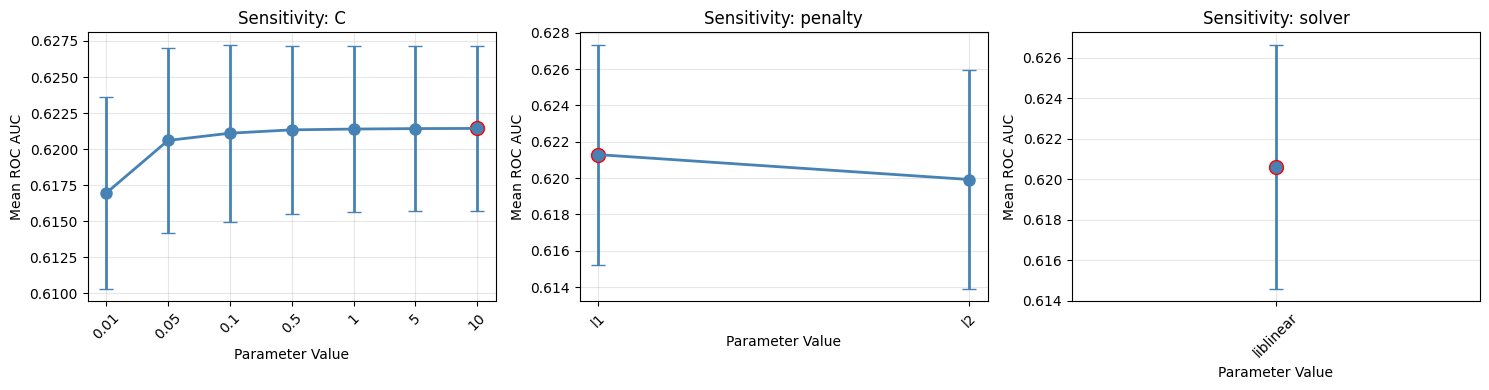

ROC AUC: 0.6228
Classification Report:
:               precision    recall  f1-score   support

           0       0.81      0.59      0.69      7735
           1       0.31      0.57      0.40      2442

    accuracy                           0.59     10177
   macro avg       0.56      0.58      0.54     10177
weighted avg       0.69      0.59      0.62     10177

5 fold cross validation ROC AUC: 0.6214 (±0.0057)
Best params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross validation score: 0.6214
Test set ROC AUC: 0.6228


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

def plot_parameter_sensitivity(grid_search, param_grid):
    """绘制逻辑回归参数敏感性分析图"""
    results = grid_search.cv_results_
    param_names = list(param_grid.keys())

    # 根据参数数量确定子图布局
    n_params = len(param_names)
    n_cols = min(3, n_params)
    n_rows = (n_params + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_params == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, param in enumerate(param_names):
        if i < len(axes):
            # 获取该参数的所有取值和对应的平均性能
            param_values = []
            mean_scores = []
            std_scores = []

            for value in param_grid[param]:
                # 找到包含该参数值的所有组合
                indices = [idx for idx, params in enumerate(results['params'])
                          if params[param] == value]
                if indices:
                    param_values.append(str(value))
                    mean_scores.append(np.mean([results['mean_test_score'][idx] for idx in indices]))
                    std_scores.append(np.mean([results['std_test_score'][idx] for idx in indices]))

            # 绘制该参数的敏感性
            axes[i].errorbar(range(len(mean_scores)), mean_scores, yerr=std_scores,
                           fmt='o-', capsize=5, linewidth=2, markersize=8, color='steelblue')
            axes[i].set_title(f'Sensitivity: {param}', fontsize=12)
            axes[i].set_xlabel('Parameter Value')
            axes[i].set_ylabel('Mean ROC AUC')
            axes[i].set_xticks(range(len(param_values)))
            axes[i].set_xticklabels(param_values, rotation=45)
            axes[i].grid(True, alpha=0.3)

            # 标记最佳值
            best_idx = np.argmax(mean_scores)
            axes[i].plot(best_idx, mean_scores[best_idx], 'ro', markersize=10)

    # 隐藏多余的子图
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

def create_interaction_features(train_data, test_data):
    # 1. Upper_Age * Reco_Policy_Premium (数值*数值)
    train_data['Upper_Age_Premium_Interaction'] = train_data['Upper_Age'] * train_data['Reco_Policy_Premium']
    test_data['Upper_Age_Premium_Interaction'] = test_data['Upper_Age'] * test_data['Reco_Policy_Premium']

    # 2. Upper_Age * Holding_Policy_Duration (数值*数值)
    train_data['Upper_Age_Duration_Interaction'] = train_data['Upper_Age'] * train_data['Holding_Policy_Duration']
    test_data['Upper_Age_Duration_Interaction'] = test_data['Upper_Age'] * test_data['Holding_Policy_Duration']

    # 3. Upper_Age * Health_Indicator (数值*分类)
    health_mapping = {
        'X1': 1, 'X2': 2, 'X3': 3, 'X4': 4, 'X5': 5, 'X6': 6, 'X7': 7, 'X8': 8, 'X9': 9
    }
    default_health_value = 5

    train_data['Health_Indicator_encoded'] = train_data['Health_Indicator'].map(health_mapping)
    train_data['Health_Indicator_encoded'] = train_data['Health_Indicator_encoded'].fillna(default_health_value)

    test_data['Health_Indicator_encoded'] = test_data['Health_Indicator'].map(health_mapping)
    test_data['Health_Indicator_encoded'] = test_data['Health_Indicator_encoded'].fillna(default_health_value)

    train_data['Upper_Age_Health_Interaction'] = train_data['Upper_Age'] * train_data['Health_Indicator_encoded']
    test_data['Upper_Age_Health_Interaction'] = test_data['Upper_Age'] * test_data['Health_Indicator_encoded']

    # 4. Holding_Policy_Duration * Reco_Policy_Cat (数值*分类)
    train_data['Duration_PolicyCat_Interaction'] = train_data['Holding_Policy_Duration'] * train_data['Reco_Policy_Cat_enc']
    test_data['Duration_PolicyCat_Interaction'] = test_data['Holding_Policy_Duration'] * test_data['Reco_Policy_Cat_enc']

    # 5. Reco_Policy_Premium * Reco_Insurance_Type (数值*分类)
    insurance_mean = train_data.groupby('Reco_Insurance_Type')['Response'].mean()
    train_data['Reco_Insurance_Type_enc'] = train_data['Reco_Insurance_Type'].map(insurance_mean)
    test_data['Reco_Insurance_Type_enc'] = test_data['Reco_Insurance_Type'].map(insurance_mean)
    test_data['Reco_Insurance_Type_enc'] = test_data['Reco_Insurance_Type_enc'].fillna(train_data['Response'].mean())

    train_data['Premium_InsuranceType_Interaction'] = train_data['Reco_Policy_Premium'] * train_data['Reco_Insurance_Type_enc']
    test_data['Premium_InsuranceType_Interaction'] = test_data['Reco_Policy_Premium'] * test_data['Reco_Insurance_Type_enc']

    return train_data, test_data

def kfold_target_encode(train_df, column, target, n_splits=5):
    """使用K-Fold进行目标编码"""
    train_df[f'{column}_enc'] = 0
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(train_df):
        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]

        mean_encoding = train_fold.groupby(column)[target].mean()
        train_df.iloc[val_idx, train_df.columns.get_loc(f'{column}_enc')] = \
            val_fold[column].map(mean_encoding).fillna(train_df[target].mean())

    return train_df

def tune_logistic_regression(X_train, y_train, scoring='roc_auc'):
    # 定义参数网格
    param_grid = {
        'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }

    grid_search = GridSearchCV(
        estimator=LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        param_grid=param_grid,
        scoring=scoring,
        cv=5,
        n_jobs=1,
        verbose=100
    )

    grid_search.fit(X_train, y_train)

    print(f"Best params: {grid_search.best_params_}")
    print(f"Best cross validation {scoring} score: {grid_search.best_score_:.4f}")

    # 添加参数敏感性分析
    plot_parameter_sensitivity(grid_search, param_grid)

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_, grid_search

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr,tpr,_ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:\n:",classification_report(y_test, y_pred))

    return {
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'fpr':fpr,
        'tpr':tpr
    }

def prepare_features_with_kfold_encoding(X_train, y_train, X_test, n_splits=5):
    target_encode_cols = ['Reco_Policy_Cat', 'City_Code', 'Region_Code']

    train_data = X_train.copy()
    test_data = X_test.copy()
    train_data['Response'] = y_train.values

    for col in target_encode_cols:
        train_data = kfold_target_encode(train_data, col, 'Response', n_splits)
        global_mean = train_data.groupby(col)['Response'].mean()
        test_data[f'{col}_enc'] = test_data[col].map(global_mean)
        test_data[f'{col}_enc'] = test_data[f'{col}_enc'].fillna(train_data['Response'].mean())

    train_data, test_data = create_interaction_features(train_data, test_data)

    # delete
    columns_to_drop = target_encode_cols + ['Health_Indicator_encoded', 'Reco_Insurance_Type_enc']
    train_data = train_data.drop(columns=columns_to_drop)
    test_data = test_data.drop(columns=columns_to_drop)

    onehot_cols = ['Reco_Insurance_Type', 'Accomodation_Type', 'Health_Indicator',
                  'Holding_Policy_Type', 'Is_Spouse']

    train_onehot = pd.get_dummies(train_data[onehot_cols], drop_first=True)
    test_onehot = pd.get_dummies(test_data[onehot_cols], drop_first=True)

    missing_cols = set(train_onehot.columns) - set(test_onehot.columns)
    for col in missing_cols:
        test_onehot[col] = 0
    test_onehot = test_onehot[train_onehot.columns]
    num_features = ["Upper_Age", "Lower_Age", "Reco_Policy_Premium", 'Holding_Policy_Duration']
    interaction_cols = [col for col in train_data.columns if 'Interaction' in col]

    X_train_final = pd.concat([
        train_data.drop(columns=onehot_cols + ['Response']),
        train_onehot,
        train_data[num_features + interaction_cols]
    ], axis=1)

    X_test_final = pd.concat([
        test_data.drop(columns=onehot_cols),
        test_onehot,
        test_data[num_features + interaction_cols]
    ], axis=1)
    features_to_scale = num_features + interaction_cols
    scaler = StandardScaler()
    X_train_final[features_to_scale] = scaler.fit_transform(X_train_final[features_to_scale])
    X_test_final[features_to_scale] = scaler.transform(X_test_final[features_to_scale])

    return X_train_final, X_test_final, train_data['Response']

def train_with_parameter_tuning(X_train, y_train, X_test, y_test, scoring='roc_auc'):
    X_train_final, X_test_final, y_train_final = prepare_features_with_kfold_encoding(
        X_train, y_train, X_test
    )

    best_model, best_params, best_score, grid_search = tune_logistic_regression(
        X_train_final, y_train_final, scoring
    )

    # Evaluation
    evaluation_results = evaluate_model(best_model, X_test_final, y_test)

    # Cross validation
    cv_scores = cross_val_score(best_model, X_train_final, y_train_final,
                               cv=5, scoring='roc_auc')
    print(f"5 fold cross validation ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    return {
        'model': best_model,
        'best_params': best_params,
        'best_cv_score': best_score,
        'X_train': X_train_final,
        'X_test': X_test_final,
        'y_train': y_train_final,
        'y_test': y_test,
        'evaluation': evaluation_results,
        'cv_scores': cv_scores,
        'grid_search': grid_search
    }

if __name__ == "__main__":
    data = pd.read_csv("clean.csv")
    X = data.drop(columns=["Response","ID","Unnamed: 0"])
    y = data["Response"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    result = train_with_parameter_tuning(X_train, y_train, X_test, y_test, scoring='roc_auc')
    fpr_fe5 = result['evaluation']['fpr']
    tpr_fe5 = result['evaluation']['tpr']
    auc_fe5 = result['evaluation']['roc_auc']
    print(f"Best params: {result['best_params']}")
    print(f"Best cross validation score: {result['best_cv_score']:.4f}")
    print(f"Test set ROC AUC: {result['evaluation']['roc_auc']:.4f}")

## ROC

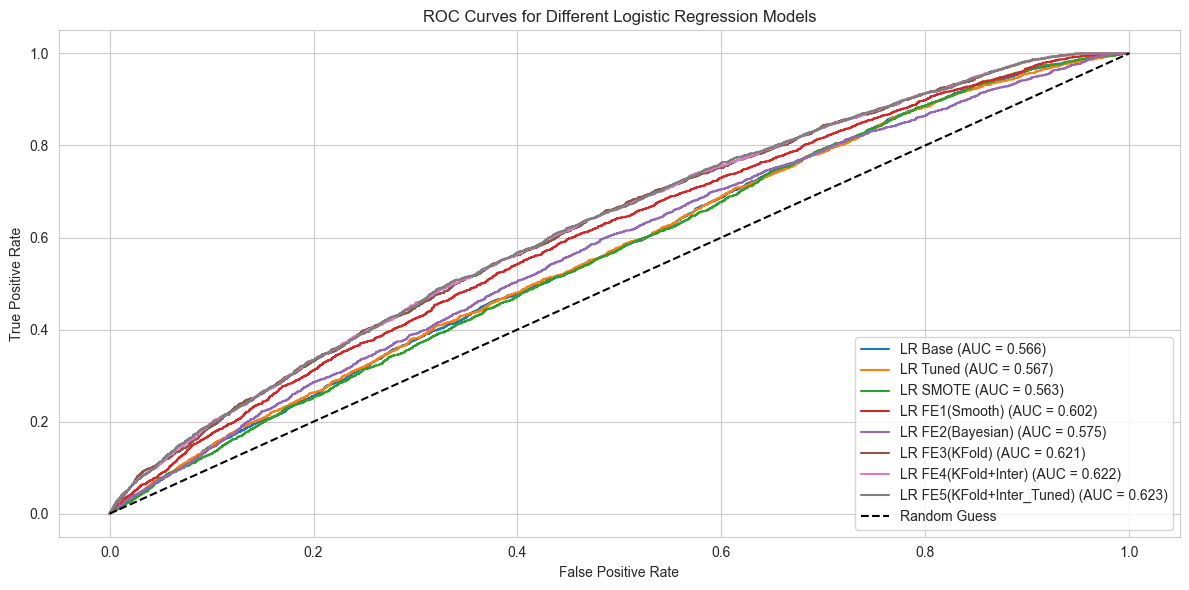

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(fpr_base,  tpr_base,  label=f"LR Base (AUC = {auc_base:.3f})")
plt.plot(fpr_tuned,  tpr_tuned,  label=f"LR Tuned (AUC = {auc_tuned:.3f})")
plt.plot(fpr_sm,  tpr_sm,  label=f"LR SMOTE (AUC = {auc_sm:.3f})")
plt.plot(fpr_fe1,  tpr_fe1,  label=f"LR FE1(Smooth) (AUC = {auc_fe1:.3f})")
plt.plot(fpr_fe2,  tpr_fe2,  label=f"LR FE2(Bayesian) (AUC = {auc_fe2:.3f})")
plt.plot(fpr_fe3,  tpr_fe3,  label=f"LR FE3(KFold) (AUC = {auc_fe3:.3f})")
plt.plot(fpr_fe4, tpr_fe4, label=f"LR FE4(KFold+Inter) (AUC = {auc_fe4:.3f})")
plt.plot(fpr_fe5, tpr_fe5, label=f"LR FE5(KFold+Inter_Tuned) (AUC = {auc_fe5:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Logistic Regression Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()